# Double asperity simulations

In the previous tutorial, we looked at a rather simple configuration, that of a single asperity which exhibited repetitive, stable limit cycles. In this tutorial, we'll consider a fault with two asperities, one of size $f L_a$, and another of size $(1-f)L_a$. We begin with $f = 0.5$, meaning that both asperities are of equal size $0.5 L_a$. Later on, we can tune this parameter $f$ to see how the behaviour changes.

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.join("/", "home")
qdyn_dir = os.path.join(base_dir, "qdyn", "src")
plot_dir = os.path.join(base_dir, "qdyn", "utils", "post_processing")
sys.path.append(qdyn_dir)
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

We prepare the simulation in a similar way as we have done in the single asperity case:

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
f = 0.5                     # Size ratio of asperities
L = 15                      # Length of fault / nucleation length
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 1         # Finite fault
set_dict["TMAX"] = 25*t_yr     # Maximum simulation time [s]
set_dict["NTOUT"] = 100        # Save output every N steps
set_dict["NXOUT"] = 2          # Snapshot resolution (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity [m/s]
set_dict["MU"] = 3e10          # Shear modulus [Pa]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 1.2e-2    # Direct effect
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = Lb / cab_ratio
# Fault length [m]
L *= Lc
L1 = 0.5 * f * L
L2 = 0.5 * (1 - f) * L
p1 = L / 3 - L / 2
p2 = 2 * L / 3 - L / 2

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)
asp1 = (x > (p1 - L1 / 2)) & (x < (p1 + L1 / 2))
asp2 = (x > (p2 - L2 / 2)) & (x < (p2 + L2 / 2))

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Location on the fault (middle) for time series output
set_dict["IC"] = N // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"][asp1 + asp2] = ab_ratio * p.mesh_dict["B"][asp1 + asp2]

# Write input to qdyn.in
p.write_input()

True

We can visualise the two asperities by plotting $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


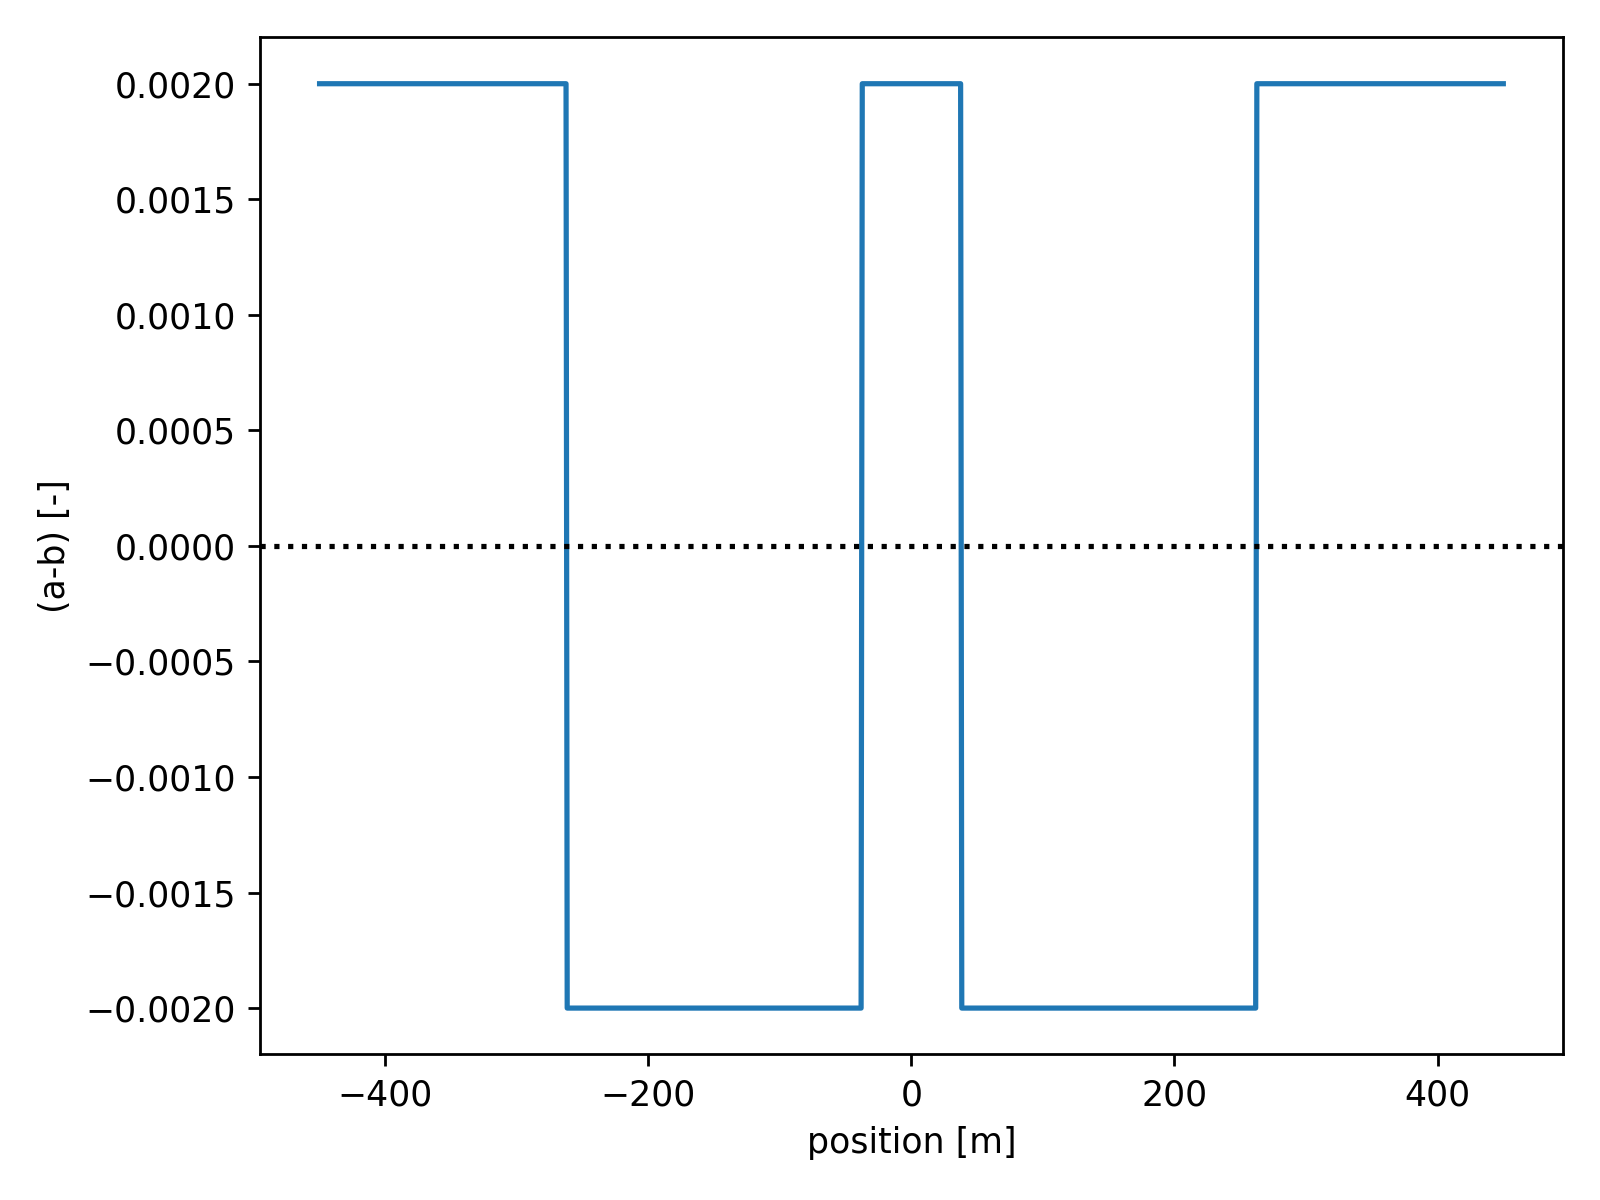

In [3]:
plt.clf()
plt.plot(x, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [m]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
plt.show()

We then run this simulation with `p.run()`

In [4]:
p.run()

 Number of processors =            1
 Start reading input ...
    Mesh input complete
   Flags input complete
 Input complete
 Initializing mesh ...
 1D fault, uniform grid
 Impedance =    5000000.0000000000     
 Intializing kernel: ...
 FFT applied
 Reading kernel /home/qdyn/src/kernel_I.tab
 Kernel intialized
 Values at selected point of the fault:
 K/Kc =  -0.20943951023931953     
 K/Kb =    4.1887902047863905E-002

     it,  dt (secs), time (yrs), v_max (m/s), sigma_max (MPa)
 Initialising RK45 solver
 Finished initialising RK45 solver
 Initialization completed
      0   0.000E+00   0.000E+00   0.101E-04   0.100E+03
    100   0.110E-02   0.102E-05   0.424E-01   0.100E+03
    200   0.455E-04   0.102E-05   0.130E+01   0.100E+03
    300   0.332E-04   0.102E-05   0.171E+01   0.100E+03
    400   0.286E-04   0.102E-05   0.195E+01   0.100E+03
    500   0.262E-04   0.102E-05   0.212E+01   0.100E+03
    600   0.246E-04   0.102E-05   0.226E+01   0.100E+03
    700   0.233E-04   0.102E-05   

  14200   0.830E+00   0.199E+01   0.460E-04   0.100E+03
  14300   0.128E+01   0.199E+01   0.267E-04   0.100E+03
  14400   0.217E+01   0.199E+01   0.160E-04   0.100E+03
  14500   0.393E+01   0.199E+01   0.984E-05   0.100E+03
  14600   0.604E+01   0.199E+01   0.623E-05   0.100E+03
  14700   0.937E+01   0.199E+01   0.406E-05   0.100E+03
  14800   0.140E+02   0.199E+01   0.269E-05   0.100E+03
  14900   0.206E+02   0.199E+01   0.183E-05   0.100E+03
  15000   0.303E+02   0.199E+01   0.127E-05   0.100E+03
  15100   0.437E+02   0.199E+01   0.900E-06   0.100E+03
  15200   0.624E+02   0.199E+01   0.648E-06   0.100E+03
  15300   0.891E+02   0.199E+01   0.473E-06   0.100E+03
  15400   0.123E+03   0.199E+01   0.349E-06   0.100E+03
  15500   0.175E+03   0.199E+01   0.254E-06   0.100E+03
  15600   0.473E+03   0.199E+01   0.717E-07   0.100E+03
  15700   0.147E+05   0.201E+01   0.315E-08   0.100E+03
  15800   0.104E+06   0.223E+01   0.965E-09   0.100E+03
  15900   0.995E+05   0.255E+01   0.971E-09   0.

  29500   0.114E-03   0.568E+01   0.304E+00   0.100E+03
  29600   0.112E-03   0.568E+01   0.315E+00   0.100E+03
  29700   0.112E-03   0.568E+01   0.327E+00   0.100E+03
  29800   0.110E-03   0.568E+01   0.339E+00   0.100E+03
  29900   0.102E-03   0.568E+01   0.350E+00   0.100E+03
  30000   0.100E-03   0.568E+01   0.363E+00   0.100E+03
  30100   0.110E-03   0.568E+01   0.333E+00   0.100E+03
  30200   0.216E-03   0.568E+01   0.159E+00   0.100E+03
  30300   0.562E-03   0.568E+01   0.580E-01   0.100E+03
  30400   0.746E-03   0.568E+01   0.576E-01   0.100E+03
  30500   0.819E-03   0.568E+01   0.443E-01   0.100E+03
  30600   0.976E-03   0.568E+01   0.358E-01   0.100E+03
  30700   0.104E-02   0.568E+01   0.340E-01   0.100E+03
  30800   0.873E-03   0.568E+01   0.433E-01   0.100E+03
  30900   0.390E-03   0.568E+01   0.142E+00   0.100E+03
  31000   0.495E-04   0.568E+01   0.109E+01   0.100E+03
  31100   0.296E-03   0.568E+01   0.352E+00   0.100E+03
  31200   0.318E-03   0.568E+01   0.190E+00   0.

  44800   0.111E-02   0.753E+01   0.340E-01   0.100E+03
  44900   0.106E-02   0.753E+01   0.343E-01   0.100E+03
  45000   0.645E-03   0.753E+01   0.757E-01   0.100E+03
  45100   0.154E-03   0.753E+01   0.353E+00   0.100E+03
  45200   0.136E-03   0.753E+01   0.380E+00   0.100E+03
  45300   0.247E-03   0.753E+01   0.172E+00   0.100E+03
  45400   0.438E-03   0.753E+01   0.942E-01   0.100E+03
  45500   0.731E-03   0.753E+01   0.569E-01   0.100E+03
  45600   0.347E-03   0.753E+01   0.146E+00   0.100E+03
  45700   0.236E-03   0.753E+01   0.185E+00   0.100E+03
  45800   0.263E-03   0.753E+01   0.175E+00   0.100E+03
  45900   0.272E-03   0.753E+01   0.154E+00   0.100E+03
  46000   0.303E-03   0.753E+01   0.129E+00   0.100E+03
  46100   0.347E-03   0.753E+01   0.106E+00   0.100E+03
  46200   0.416E-03   0.753E+01   0.852E-01   0.100E+03
  46300   0.515E-03   0.753E+01   0.680E-01   0.100E+03
  46400   0.669E-03   0.753E+01   0.536E-01   0.100E+03
  46500   0.828E-03   0.753E+01   0.417E-01   0.

  59600   0.740E+00   0.907E+01   0.400E-04   0.100E+03
  59700   0.881E+00   0.907E+01   0.349E-04   0.100E+03
  59800   0.104E+01   0.907E+01   0.300E-04   0.100E+03
  59900   0.117E+01   0.907E+01   0.252E-04   0.100E+03
  60000   0.149E+01   0.907E+01   0.209E-04   0.100E+03
  60100   0.172E+01   0.907E+01   0.173E-04   0.100E+03
  60200   0.216E+01   0.907E+01   0.141E-04   0.100E+03
  60300   0.271E+01   0.907E+01   0.114E-04   0.100E+03
  60400   0.333E+01   0.907E+01   0.911E-05   0.100E+03
  60500   0.432E+01   0.907E+01   0.721E-05   0.100E+03
  60600   0.539E+01   0.907E+01   0.568E-05   0.100E+03
  60700   0.701E+01   0.907E+01   0.441E-05   0.100E+03
  60800   0.945E+01   0.907E+01   0.336E-05   0.100E+03
  60900   0.124E+02   0.907E+01   0.253E-05   0.100E+03
  61000   0.171E+02   0.907E+01   0.187E-05   0.100E+03
  61100   0.236E+02   0.907E+01   0.136E-05   0.100E+03
  61200   0.336E+02   0.907E+01   0.987E-06   0.100E+03
  61300   0.476E+02   0.907E+01   0.724E-06   0.

  74400   0.288E+04   0.111E+02   0.132E-07   0.100E+03
  74500   0.163E+04   0.111E+02   0.234E-07   0.100E+03
  74600   0.797E+03   0.111E+02   0.471E-07   0.100E+03
  74700   0.397E+03   0.111E+02   0.929E-07   0.100E+03
  74800   0.218E+03   0.111E+02   0.158E-06   0.100E+03
  74900   0.265E+03   0.111E+02   0.104E-06   0.100E+03
  75000   0.981E+02   0.111E+02   0.452E-06   0.100E+03
  75100   0.554E+02   0.111E+02   0.710E-06   0.100E+03
  75200   0.424E+02   0.111E+02   0.873E-06   0.100E+03
  75300   0.362E+02   0.111E+02   0.102E-05   0.100E+03
  75400   0.309E+02   0.111E+02   0.116E-05   0.100E+03
  75500   0.270E+02   0.111E+02   0.130E-05   0.100E+03
  75600   0.250E+02   0.111E+02   0.135E-05   0.100E+03
  75700   0.113E+03   0.111E+02   0.271E-06   0.100E+03
  75800   0.743E+03   0.111E+02   0.556E-07   0.100E+03
  75900   0.170E+04   0.111E+02   0.236E-07   0.100E+03
  76000   0.462E+04   0.111E+02   0.954E-08   0.100E+03
  76100   0.110E+05   0.112E+02   0.456E-08   0.

  89100   0.210E+01   0.123E+02   0.151E-04   0.100E+03
  89200   0.188E+01   0.123E+02   0.163E-04   0.100E+03
  89300   0.185E+01   0.123E+02   0.164E-04   0.100E+03
  89400   0.201E+01   0.123E+02   0.156E-04   0.100E+03
  89500   0.213E+01   0.123E+02   0.144E-04   0.100E+03
  89600   0.229E+01   0.123E+02   0.130E-04   0.100E+03
  89700   0.272E+01   0.123E+02   0.115E-04   0.100E+03
  89800   0.318E+01   0.123E+02   0.995E-05   0.100E+03
  89900   0.361E+01   0.123E+02   0.849E-05   0.100E+03
  90000   0.431E+01   0.123E+02   0.713E-05   0.100E+03
  90100   0.545E+01   0.123E+02   0.589E-05   0.100E+03
  90200   0.643E+01   0.123E+02   0.480E-05   0.100E+03
  90300   0.821E+01   0.123E+02   0.383E-05   0.100E+03
  90400   0.102E+02   0.123E+02   0.302E-05   0.100E+03
  90500   0.134E+02   0.123E+02   0.234E-05   0.100E+03
  90600   0.180E+02   0.123E+02   0.178E-05   0.100E+03
  90700   0.251E+02   0.123E+02   0.133E-05   0.100E+03
  90800   0.327E+02   0.123E+02   0.979E-06   0.

 103800   0.277E+03   0.143E+02   0.131E-06   0.100E+03
 103900   0.237E+03   0.143E+02   0.125E-06   0.100E+03
 104000   0.161E+03   0.143E+02   0.301E-06   0.100E+03
 104100   0.730E+02   0.143E+02   0.535E-06   0.100E+03
 104200   0.557E+02   0.143E+02   0.670E-06   0.100E+03
 104300   0.473E+02   0.143E+02   0.785E-06   0.100E+03
 104400   0.402E+02   0.143E+02   0.898E-06   0.100E+03
 104500   0.350E+02   0.143E+02   0.101E-05   0.100E+03
 104600   0.323E+02   0.143E+02   0.106E-05   0.100E+03
 104700   0.138E+03   0.143E+02   0.235E-06   0.100E+03
 104800   0.951E+03   0.143E+02   0.464E-07   0.100E+03
 104900   0.213E+04   0.143E+02   0.191E-07   0.100E+03
 105000   0.579E+04   0.143E+02   0.779E-08   0.100E+03
 105100   0.797E+04   0.144E+02   0.500E-08   0.100E+03
 105200   0.148E+04   0.144E+02   0.262E-07   0.100E+03
 105300   0.111E+04   0.144E+02   0.312E-07   0.100E+03
 105400   0.127E+04   0.144E+02   0.259E-07   0.100E+03
 105500   0.205E+04   0.144E+02   0.154E-07   0.

 119200   0.140E+00   0.155E+02   0.223E-03   0.100E+03
 119300   0.153E+00   0.155E+02   0.204E-03   0.100E+03
 119400   0.161E+00   0.155E+02   0.187E-03   0.100E+03
 119500   0.177E+00   0.155E+02   0.170E-03   0.100E+03
 119600   0.198E+00   0.155E+02   0.154E-03   0.100E+03
 119700   0.222E+00   0.155E+02   0.137E-03   0.100E+03
 119800   0.250E+00   0.155E+02   0.121E-03   0.100E+03
 119900   0.290E+00   0.155E+02   0.105E-03   0.100E+03
 120000   0.363E+00   0.155E+02   0.906E-04   0.100E+03
 120100   0.397E+00   0.155E+02   0.771E-04   0.100E+03
 120200   0.484E+00   0.155E+02   0.646E-04   0.100E+03
 120300   0.594E+00   0.155E+02   0.536E-04   0.100E+03
 120400   0.707E+00   0.155E+02   0.443E-04   0.100E+03
 120500   0.880E+00   0.155E+02   0.367E-04   0.100E+03
 120600   0.101E+01   0.155E+02   0.314E-04   0.100E+03
 120700   0.114E+01   0.155E+02   0.286E-04   0.100E+03
 120800   0.115E+01   0.155E+02   0.298E-04   0.100E+03
 120900   0.911E+00   0.155E+02   0.379E-04   0.

 133900   0.172E+01   0.168E+02   0.184E-04   0.100E+03
 134000   0.246E+01   0.168E+02   0.122E-04   0.100E+03
 134100   0.407E+01   0.168E+02   0.777E-05   0.100E+03
 134200   0.629E+01   0.168E+02   0.482E-05   0.100E+03
 134300   0.115E+02   0.168E+02   0.283E-05   0.100E+03
 134400   0.203E+02   0.168E+02   0.158E-05   0.100E+03
 134500   0.389E+02   0.168E+02   0.937E-06   0.100E+03
 134600   0.665E+02   0.168E+02   0.592E-06   0.100E+03
 134700   0.105E+03   0.168E+02   0.385E-06   0.100E+03
 134800   0.163E+03   0.168E+02   0.257E-06   0.100E+03
 134900   0.255E+03   0.168E+02   0.175E-06   0.100E+03
 135000   0.384E+03   0.168E+02   0.120E-06   0.100E+03
 135100   0.611E+03   0.168E+02   0.787E-07   0.100E+03
 135200   0.267E+03   0.168E+02   0.220E-06   0.100E+03
 135300   0.850E+02   0.168E+02   0.442E-06   0.100E+03
 135400   0.278E+03   0.168E+02   0.139E-06   0.100E+03
 135500   0.196E+04   0.168E+02   0.263E-07   0.100E+03
 135600   0.308E+05   0.169E+02   0.165E-08   0.

 148600   0.138E+03   0.187E+02   0.227E-06   0.100E+03
 148700   0.173E+03   0.187E+02   0.177E-06   0.100E+03
 148800   0.270E+03   0.187E+02   0.108E-06   0.100E+03
 148900   0.604E+03   0.187E+02   0.507E-07   0.100E+03
 149000   0.153E+04   0.187E+02   0.193E-07   0.100E+03
 149100   0.493E+04   0.187E+02   0.622E-08   0.100E+03
 149200   0.678E+04   0.188E+02   0.498E-08   0.100E+03
 149300   0.108E+05   0.188E+02   0.306E-08   0.100E+03
 149400   0.211E+05   0.188E+02   0.167E-08   0.100E+03
 149500   0.215E+05   0.189E+02   0.186E-08   0.100E+03
 149600   0.374E+03   0.189E+02   0.159E-06   0.100E+03
 149700   0.277E+03   0.189E+02   0.127E-06   0.100E+03
 149800   0.353E+03   0.189E+02   0.105E-06   0.100E+03
 149900   0.357E+03   0.189E+02   0.107E-06   0.100E+03
 150000   0.304E+03   0.189E+02   0.122E-06   0.100E+03
 150100   0.254E+03   0.189E+02   0.148E-06   0.100E+03
 150200   0.209E+03   0.189E+02   0.176E-06   0.100E+03
 150300   0.321E+03   0.189E+02   0.112E-06   0.

 163500   0.111E+05   0.208E+02   0.355E-08   0.100E+03
 163600   0.799E+04   0.208E+02   0.480E-08   0.100E+03
 163700   0.523E+04   0.208E+02   0.727E-08   0.100E+03
 163800   0.311E+04   0.208E+02   0.123E-07   0.100E+03
 163900   0.161E+04   0.208E+02   0.232E-07   0.100E+03
 164000   0.797E+03   0.209E+02   0.470E-07   0.100E+03
 164100   0.371E+03   0.209E+02   0.966E-07   0.100E+03
 164200   0.188E+03   0.209E+02   0.185E-06   0.100E+03
 164300   0.105E+03   0.209E+02   0.319E-06   0.100E+03
 164400   0.102E+03   0.209E+02   0.276E-06   0.100E+03
 164500   0.234E+02   0.209E+02   0.175E-05   0.100E+03
 164600   0.133E+02   0.209E+02   0.273E-05   0.100E+03
 164700   0.104E+02   0.209E+02   0.340E-05   0.100E+03
 164800   0.840E+01   0.209E+02   0.406E-05   0.100E+03
 164900   0.739E+01   0.209E+02   0.477E-05   0.100E+03
 165000   0.617E+01   0.209E+02   0.560E-05   0.100E+03
 165100   0.498E+01   0.209E+02   0.660E-05   0.100E+03
 165200   0.426E+01   0.209E+02   0.773E-05   0.

 178700   0.997E+00   0.220E+02   0.290E-04   0.100E+03
 178800   0.758E+00   0.220E+02   0.381E-04   0.100E+03
 178900   0.561E+00   0.220E+02   0.516E-04   0.100E+03
 179000   0.419E+00   0.220E+02   0.726E-04   0.100E+03
 179100   0.281E+00   0.220E+02   0.106E-03   0.100E+03
 179200   0.181E+00   0.220E+02   0.161E-03   0.100E+03
 179300   0.112E+00   0.220E+02   0.254E-03   0.100E+03
 179400   0.695E-01   0.220E+02   0.422E-03   0.100E+03
 179500   0.399E-01   0.220E+02   0.734E-03   0.100E+03
 179600   0.209E-01   0.220E+02   0.134E-02   0.100E+03
 179700   0.108E-01   0.220E+02   0.263E-02   0.100E+03
 179800   0.521E-02   0.220E+02   0.550E-02   0.100E+03
 179900   0.254E-02   0.220E+02   0.128E-01   0.100E+03
 180000   0.955E-03   0.220E+02   0.319E-01   0.100E+03
 180100   0.430E-03   0.220E+02   0.705E-01   0.100E+03
 180200   0.335E-03   0.220E+02   0.115E+00   0.100E+03
 180300   0.212E-03   0.220E+02   0.150E+00   0.100E+03
 180400   0.233E-03   0.220E+02   0.178E+00   0.

 193700   0.158E-03   0.234E+02   0.204E+00   0.100E+03
 193800   0.148E-03   0.234E+02   0.224E+00   0.100E+03
 193900   0.178E-03   0.234E+02   0.225E+00   0.100E+03
 194000   0.195E-03   0.234E+02   0.181E+00   0.100E+03
 194100   0.202E-03   0.234E+02   0.198E+00   0.100E+03
 194200   0.192E-03   0.234E+02   0.207E+00   0.100E+03
 194300   0.172E-03   0.234E+02   0.212E+00   0.100E+03
 194400   0.200E-03   0.234E+02   0.213E+00   0.100E+03
 194500   0.169E-03   0.234E+02   0.211E+00   0.100E+03
 194600   0.193E-03   0.234E+02   0.210E+00   0.100E+03
 194700   0.191E-03   0.234E+02   0.208E+00   0.100E+03
 194800   0.176E-03   0.234E+02   0.207E+00   0.100E+03
 194900   0.207E-03   0.234E+02   0.208E+00   0.100E+03
 195000   0.172E-03   0.234E+02   0.208E+00   0.100E+03
 195100   0.185E-03   0.234E+02   0.211E+00   0.100E+03
 195200   0.217E-03   0.234E+02   0.214E+00   0.100E+03
 195300   0.170E-03   0.234E+02   0.217E+00   0.100E+03
 195400   0.190E-03   0.234E+02   0.211E+00   0.

0

Then read the output:

In [5]:
p.read_output()

True

To get a general impression of how our fault behaved, we plot the time series of the shear stress $\tau$ and state $\theta$ at the centre of the fault, and maximum slip rate $v_{max}$ recorded over the entire fault.

<IPython.core.display.Javascript object>


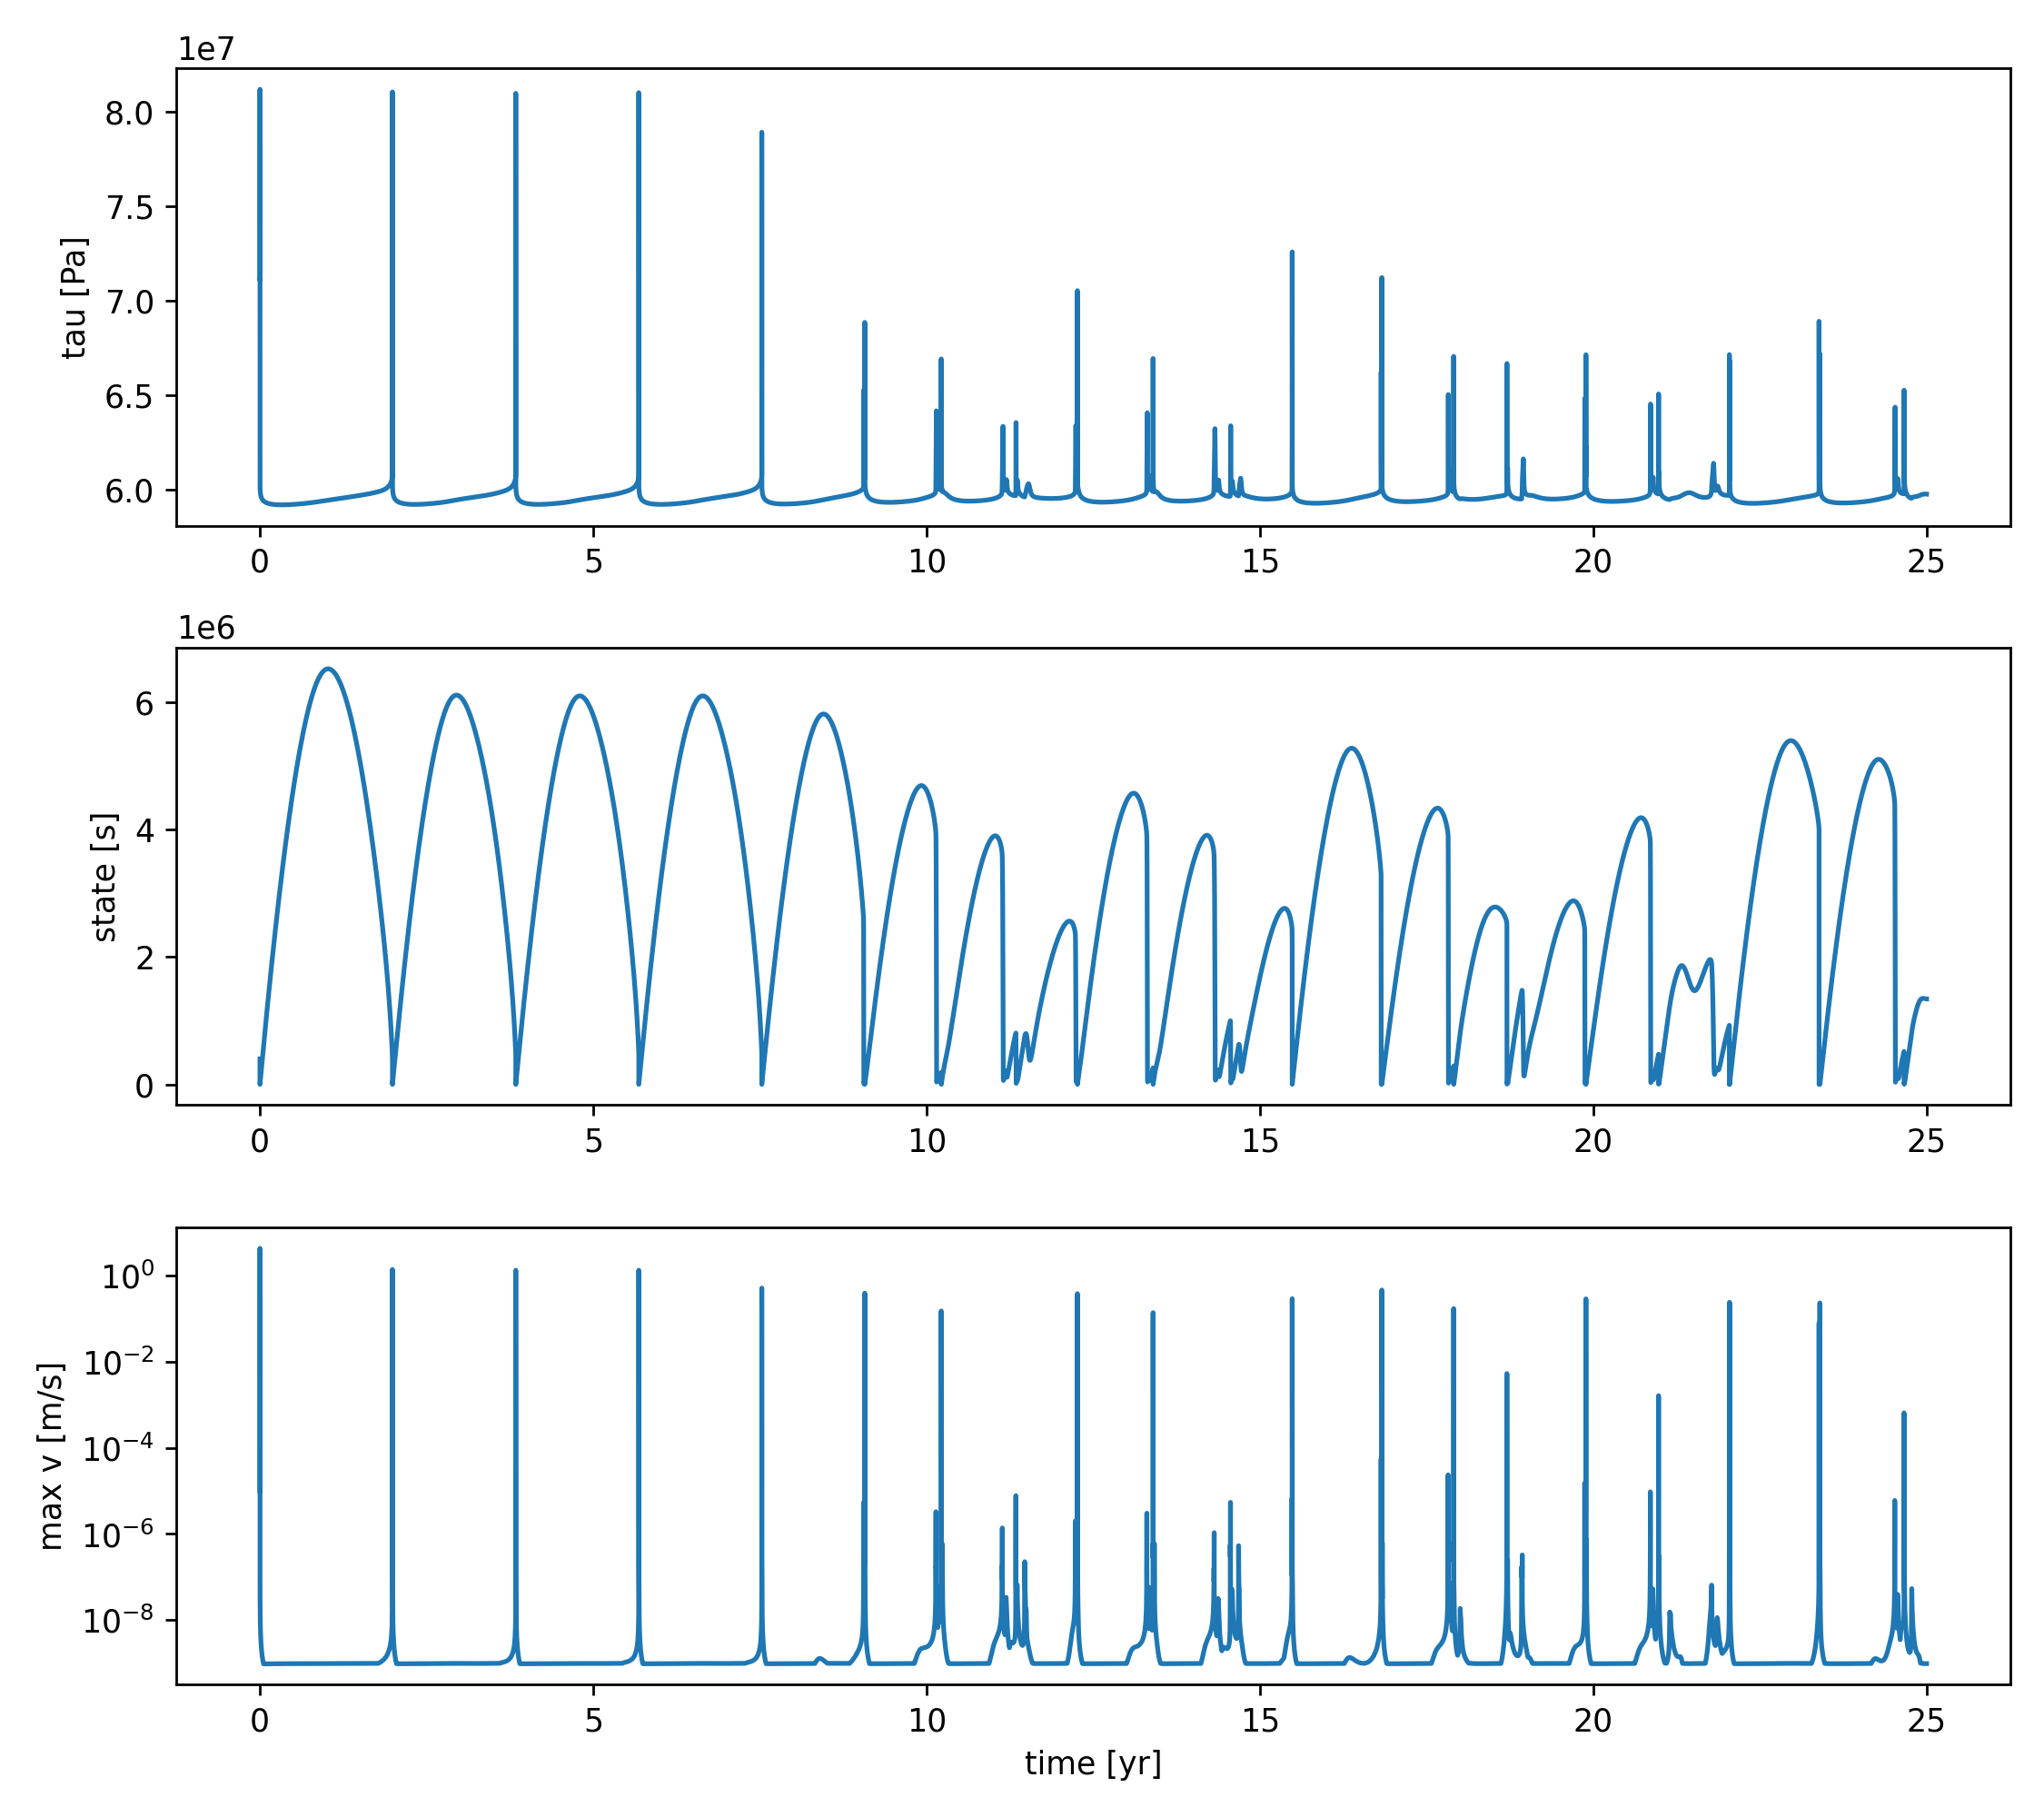

In [6]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

In this double-asperity scenario, we see the opposite of what we saw in the single-asperity case: instead of converging to a stable limit cycle, the earthquake cycles diverge into (deterministic) chaos. This is clearly illustrated by the slip rate evolution:

<IPython.core.display.Javascript object>


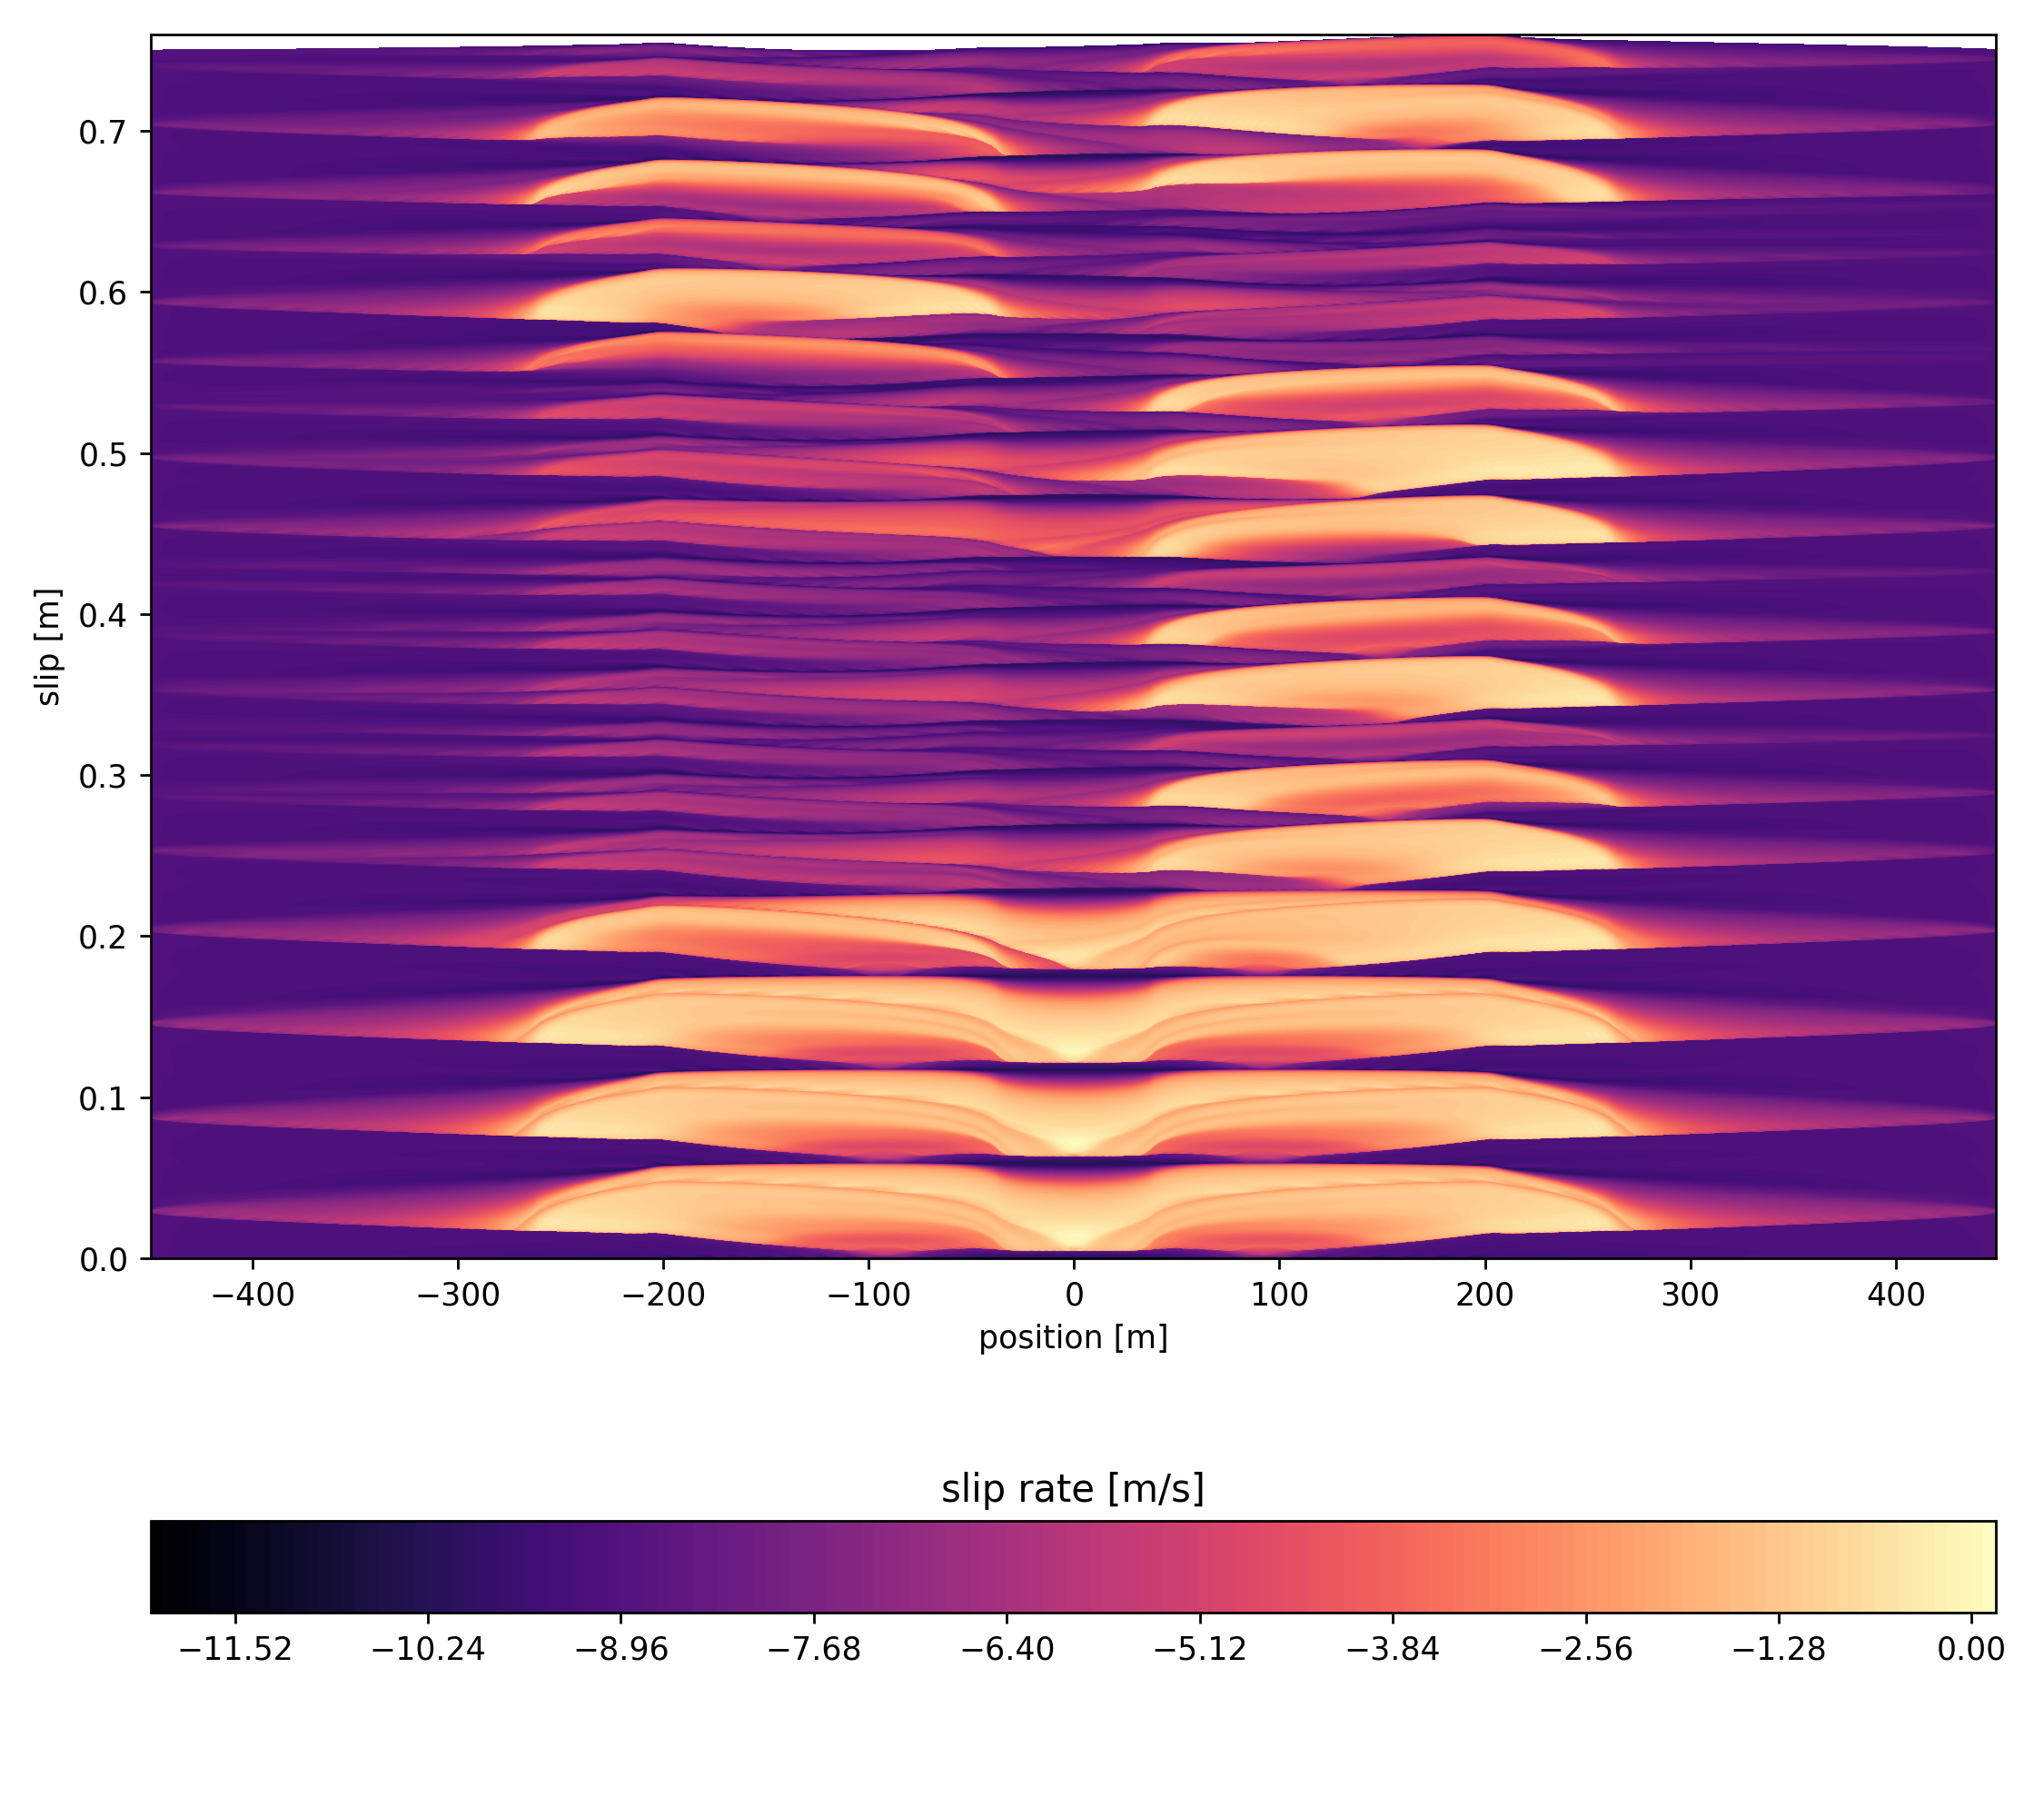

In [7]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=1*t_yr)

At first, both asperities rupture simultaneously, but after a few cycles, only the right asperity ruptures seismically while the left one mostly creeps. This pattern is reversed after a few more cycles. Another way of seeing this is with an animation:

In [8]:
# This will take a minute or two...
qdyn_plot.animation_slip(p.ox, warm_up=1*t_yr)

## Exercise

Vary `f` to see how the fault's response changes. Why does `f = 0.5` show chaotic behaviour, but not `f = 0.2`? Note that `f = 0.4` is the same as `f = 0.6` (it simply changes the order of the asperities).